We use model v5 to solve real captcha images. Then we check if each image is correctly solved. If it is we add this image to a new training dataset called `dataset_v6`.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

%matplotlib inline

import sys
sys.path.append("../../")

from pathlib import Path
import io
import urllib.parse as urlparse
import string
import random

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tqdm.auto import trange
from tqdm.auto import tqdm
import requests
from scrapy.http import TextResponse
from PIL import Image

import captchanet

data_dir = Path('/home/hadim/.data/Neural_Network/captchanet')

dataset_dir = data_dir / 'dataset_v6'
dataset_dir.mkdir(exist_ok=True, parents=True)

train_data_dir = dataset_dir / 'training'
train_data_dir.mkdir(exist_ok=True, parents=True)
val_data_dir = dataset_dir / 'validation'
val_data_dir.mkdir(exist_ok=True, parents=True)

tokenizer_path = dataset_dir / "tokenizer.json"

In [2]:
# Load tokenizer and model

model_dir = Path("/home/hadim/.data/Neural_Network/captchanet/model/")
model_name = 'v5'
model_path = model_dir / model_name

with open(model_path / 'tokenizer.json') as f:
  #tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(f.read())
  from keras_preprocessing import text
  tokenizer = text.tokenizer_from_json(f.read())
model = tf.keras.models.load_model(str(model_path / 'model'))

def captcha_solver(image):
    
  image = np.array(image)
  images = np.array([image])
  
  # The images need to be normalized t [0, 1] and resize to (224, 224).
  image_size = (224, 224)
  batch = tf.cast(images, 'float32')
  batch = tf.image.per_image_standardization(batch)
  batch = tf.image.resize(batch, image_size)

  # Run inference
  labels = model(batch)

  # Postprocess results (decode labels)
  labels = tf.argmax(labels, axis=2)
  words = tokenizer.sequences_to_texts(labels.numpy())
  words = [word.replace(' ', '') for word in words]
  
  return words[0]

In [ ]:
root_url = "https://www.referendum.interieur.gouv.fr/consultation_publique/8/"

cookies_pot = [{'incap_ses_1226_2043128': '2DYdJdlEmWYbL6kFuaADEQxZKl0AAAAAGiRH5APVrFbNVOA3UvKyEQ=='}]

success = 0
rate = 0
train_size = 0.8
word_length_max = 10

with open(tokenizer_path, 'w') as f:
  f.write(tokenizer.to_json())

train_file_index = len(list(train_data_dir.iterdir()))
val_file_index = len(list(val_data_dir.iterdir()))
  
i = 0
pbar = tqdm()
while True:
  try:
  
    letter1 = random.choice(string.ascii_uppercase)
    letter2 = random.choice(string.ascii_uppercase)
    letter3 = random.choice(string.ascii_uppercase)
    url = urlparse.urljoin(root_url, f'{letter1}/{letter2}{letter3}')

    cookies = random.choice(cookies_pot)
    session = requests.Session()
    requests.utils.add_dict_to_cookiejar(session.cookies, cookies)

    req = session.get(url)
    response = TextResponse(str(req.url), body=req.text, encoding='utf-8')

    iframe_src = response.css('iframe').xpath('@src').get()
    if iframe_src and 'Incapsula' in iframe_src:
      raise Exception("Incapsula issue.")

    captcha = response.css('img#captcha').xpath('@src').get()

    if not captcha:
      raise Exception("Captcha not here.")

    # Get the token
    token = response.css('#form__token').xpath('@value').get()

    # Get the image captcha URL
    captcha_uri = response.css('img#captcha').xpath('@src').get()
    captcha_url = urlparse.urljoin(root_url, captcha_uri)

    # Download the image
    req = session.get(captcha_url)
    captcha_image = Image.open(io.BytesIO(req.content))

    # Solve the captcha
    captcha_solution = captcha_solver(captcha_image)

    # Send captcha solution.
    form_data = {}
    form_data['form[captcha]'] = captcha_solution
    form_data['form[_token]'] = token

    # Get the actual page.
    req = session.post(url, data=form_data)
    response = TextResponse(str(req.url), body=req.text, encoding='utf-8')

    iframe_src = response.css('iframe').xpath('@src').get()
    if iframe_src and 'Incapsula' in iframe_src:
      raise Exception("Incapsula issue.")

    captcha = response.css('img#captcha').xpath('@src').get()

    if not captcha:
      success += 1

      # Create TF feature and save it
      if np.random.random() < train_size:
        writer_path = train_data_dir / f"{train_file_index:08d}.tfrecord"
        train_file_index += 1
      else:
        writer_path = val_data_dir / f"{val_file_index:08d}.tfrecord"
        val_file_index += 1

      # Save data to TFRecord.
      writer = tf.io.TFRecordWriter(str(writer_path))
      example = captchanet.encode_data(np.asarray(captcha_image), captcha_solution, tokenizer, word_length_max)  
      writer.write(example.SerializeToString())
      writer.close()

    i += 1
    rate = (success / i) * 100
    text = f"{rate:.1f}% success rate ({success}/{i})"
    pbar.set_description(text)
    pbar.update()
    
  except (requests.ConnectionError, requests.ChunkedEncodingError):
    pass
  
pbar.close()

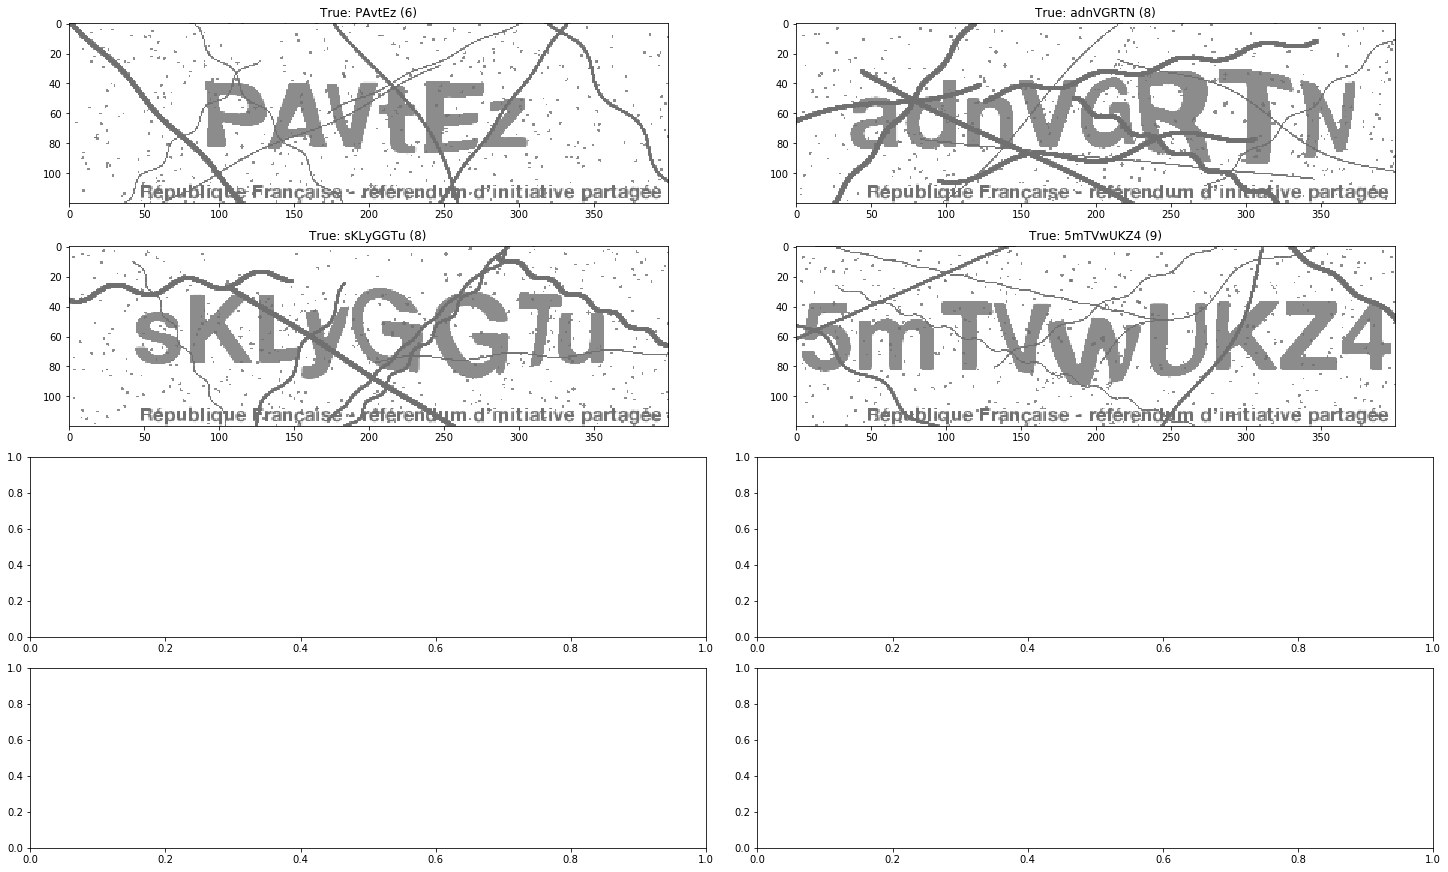

In [4]:
# Check the dataset by displaying some images.

n  = 8
fnames = [str(p) for p in train_data_dir.glob("*.tfrecord")]
dataset = tf.data.TFRecordDataset(fnames)
dataset = dataset.map(map_func=captchanet.decode_data(tokenizer, max_len_word=10, input_as_dict=True))
dataset = dataset.shuffle(1024)
dataset = dataset.batch(n)
data = [d for d in dataset.take(1)][0]

images = data['image']
labels = data['label']

# Plot
original_images = data['original_image'].numpy()
words = data['word'].numpy()
words = [w.decode('utf-8') for w in words]

size = 3
ncols = 2
nrows = n // ncols
ratio = images.shape[2] / images.shape[1]
figsize = (ncols * size * ratio, size * nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
axs = axs.flatten()

for image, word, ax in zip(original_images, words, axs):
  ax.imshow(image)
  text = f'True: {word} ({len(word)})'
  ax.set_title(text)